## Import

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# data import
df_s = pd.read_csv('df_s_concave.csv')
df_s_true = pd.read_csv('df_s_true_concave.csv')
df_t = pd.read_csv('df_t_concave.csv')
df_t_true = pd.read_csv('df_t_true_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_concave.csv')
for i in range(4):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_concave.csv')")

In [4]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(4):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    temp_list = [0 for inner_i in range(6)]
    temp_list[i] = 1
    temp_matrix = [temp_list for inner_j in range(len(eval(f"x_t{i}")))]
    temp_matrix = torch.tensor(temp_matrix)
    exec(f"x_t{i} = torch.cat([x_t{i}, temp_matrix], axis=1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
x_t4 = copy.deepcopy(x_s)
temp_list = [0 for inner_i in range(6)]
temp_list[4] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t4))]
temp_matrix = torch.tensor(temp_matrix)
x_t4 = torch.cat([x_t4, temp_matrix], axis=1).type(torch.float32)
y_t4 = copy.deepcopy(y_s)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t))]
temp_matrix = torch.tensor(temp_matrix)
x_t = torch.cat([x_t, temp_matrix], axis=1).type(torch.float32)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t_labeled))]
temp_matrix = torch.tensor(temp_matrix)
x_t_labeled = torch.cat([x_t_labeled, temp_matrix], axis=1).type(torch.float32)

## DARC

In [5]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.fe = nn.Linear(1+(4+1+1), 40)
        self.mid1 = nn.Linear(40,40)
        self.mid2 = nn.Linear(40,40)
        self.mid4 = nn.Linear(40, 1)
        self.relu = nn.ReLU()


    def forward_one(self, x):
        x = self.fe(x)
        x = self.relu(x)
        x = self.mid1(x)
        x = self.relu(x)
        x = self.mid2(x)
        x = self.relu(x)
        x = self.mid4(x)
        x = self.relu(x)
        
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### Meta-Learning

In [7]:
experiment_num = 5
darc_original_vc_result = []
for experiment_i in tqdm(range(experiment_num)):
    model = Siamese()

    # Set the Training Parameters
    lr = 1e-3
    best_model = copy.deepcopy(model)
    best_loss = 10000000

    total_domain_num = 4 + 1 + 1
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    bn = 30*total_domain_num//2

    total_x = x_t_labeled
    total_y = y_t_labeled
    # sample = random.sample(range(len(eval(f"x_t{i}"))), bn)
    for i in range(total_domain_num - 1):
        total_x = torch.cat([total_x, eval(f"x_t{i}")],axis=0)
        total_y = torch.cat([total_y, eval(f"y_t{i}")],axis=0)

    for outer_epoch in range(10000):
        temp_loss = 0
        for inner_epoch in range(5):
            

            sample1 = random.sample(range(len(total_x)), bn)
            sample2 = random.sample(range(len(total_x)), bn)
            
            xi = total_x[sample1]
            xj = total_x[sample2]
            yi = total_y[sample1]
            yj = total_y[sample2]

            optimizer.zero_grad()
            y_dist = torch.abs(yi - yj)
            z1,z2 = model(xi, xj)
            distance = F.pairwise_distance(z1,z2,keepdim=True)


            psp_loss = torch.abs(y_dist - distance).mean()    
            psp_loss.backward()
            optimizer.step()
            temp_loss += psp_loss
        if outer_epoch % 100 == 99:
            print(f"epoch : {outer_epoch}, train loss : {temp_loss.detach().item()/5}")
        
    MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
    # MLPR = LinearRegression()
    latent_source_x = torch.tensor([])
    latent_source_y = torch.tensor([])
    for i in range(5):
        latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
        latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
    latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
    latent_source_x = np.array(latent_source_x)
    latent_source_y = np.array(latent_source_y)
    latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

    MLPR.fit(latent_source_x, latent_source_y)
    print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

    darc_original_vc_result.append([mean_squared_error(MLPR.predict(latent_target_x), y_t),mean_squared_error(MLPR.predict(latent_target_x), y_t_true)])
    pd.DataFrame(MLPR.predict(latent_source_x), columns=['y_hat']).to_csv(f'DARC_SDE_C_MODEL{experiment_i}.csv', index=0)
    pd.DataFrame(darc_original_vc_result, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('DARC_SDE_C_RESULT.csv', index=0)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 99, train loss : 0.5055437088012695
epoch : 199, train loss : 0.4905202388763428
epoch : 299, train loss : 0.28863372802734377
epoch : 399, train loss : 0.21798384189605713
epoch : 499, train loss : 0.19841910600662233
epoch : 599, train loss : 0.2000131845474243
epoch : 699, train loss : 0.17877933979034424
epoch : 799, train loss : 0.17598787546157837
epoch : 899, train loss : 0.1729727268218994
epoch : 999, train loss : 0.18755942583084106
epoch : 1099, train loss : 0.17490119934082032
epoch : 1199, train loss : 0.1811068058013916
epoch : 1299, train loss : 0.1733760118484497
epoch : 1399, train loss : 0.17137672901153564
epoch : 1499, train loss : 0.17094483375549316
epoch : 1599, train loss : 0.1706782102584839
epoch : 1699, train loss : 0.169861102104187
epoch : 1799, train loss : 0.1524919390678406
epoch : 1899, train loss : 0.16398369073867797
epoch : 1999, train loss : 0.16765434741973878
epoch : 2099, train loss : 0.14483879804611205
epoch : 2199, train loss : 0.16288

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 1/5 [03:17<13:09, 197.32s/it]

test mse : 0.0744083970785141, denoised test mse : 0.06273547559976578
epoch : 99, train loss : 0.5183769226074219
epoch : 199, train loss : 0.44630279541015627
epoch : 299, train loss : 0.23855226039886473
epoch : 399, train loss : 0.22049462795257568
epoch : 499, train loss : 0.1839837074279785
epoch : 599, train loss : 0.19074268341064454
epoch : 699, train loss : 0.17759852409362792
epoch : 799, train loss : 0.1776483654975891
epoch : 899, train loss : 0.18896324634552003
epoch : 999, train loss : 0.17816386222839356
epoch : 1099, train loss : 0.19564645290374755
epoch : 1199, train loss : 0.19711613655090332
epoch : 1299, train loss : 0.20386340618133544
epoch : 1399, train loss : 0.18660506010055541
epoch : 1499, train loss : 0.17936429977416993
epoch : 1599, train loss : 0.198627245426178
epoch : 1699, train loss : 0.1801725745201111
epoch : 1799, train loss : 0.1756264567375183
epoch : 1899, train loss : 0.17596325874328614
epoch : 1999, train loss : 0.1716862916946411
epoch : 

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 2/5 [06:11<09:10, 183.59s/it]

epoch : 9999, train loss : 0.14115521907806397
test mse : 0.08697935193777084, denoised test mse : 0.07661490142345428
epoch : 99, train loss : 0.5127280235290528
epoch : 199, train loss : 0.32497472763061525
epoch : 299, train loss : 0.2166790246963501
epoch : 399, train loss : 0.2037525177001953
epoch : 499, train loss : 0.18981778621673584
epoch : 599, train loss : 0.18695778846740724
epoch : 699, train loss : 0.18735077381134033
epoch : 799, train loss : 0.17286763191223145
epoch : 899, train loss : 0.1857219934463501
epoch : 999, train loss : 0.16641228199005126
epoch : 1099, train loss : 0.1757746696472168
epoch : 1199, train loss : 0.15395040512084962
epoch : 1299, train loss : 0.16722649335861206
epoch : 1399, train loss : 0.17346068620681762
epoch : 1499, train loss : 0.18678547143936158
epoch : 1599, train loss : 0.15273714065551758
epoch : 1699, train loss : 0.1639458179473877
epoch : 1799, train loss : 0.16476837396621705
epoch : 1899, train loss : 0.17634098529815673
epoch

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60%|██████    | 3/5 [09:12<06:04, 182.47s/it]

test mse : 0.08396106958389282, denoised test mse : 0.07276369631290436
epoch : 99, train loss : 0.5203256130218505
epoch : 199, train loss : 0.4547567367553711
epoch : 299, train loss : 0.39988007545471194
epoch : 399, train loss : 0.26437175273895264
epoch : 499, train loss : 0.23521461486816406
epoch : 599, train loss : 0.20484886169433594
epoch : 699, train loss : 0.19677118062973023
epoch : 799, train loss : 0.18994314670562745
epoch : 899, train loss : 0.19453662633895874
epoch : 999, train loss : 0.15965168476104735
epoch : 1099, train loss : 0.16896222829818724
epoch : 1199, train loss : 0.1774094820022583
epoch : 1299, train loss : 0.16534292697906494
epoch : 1399, train loss : 0.17654023170471192
epoch : 1499, train loss : 0.16644177436828614
epoch : 1599, train loss : 0.18599737882614137
epoch : 1699, train loss : 0.17628662586212157
epoch : 1799, train loss : 0.1773297071456909
epoch : 1899, train loss : 0.15634615421295167
epoch : 1999, train loss : 0.17588071823120116
epo

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 80%|████████  | 4/5 [12:08<02:59, 179.98s/it]

epoch : 9999, train loss : 0.15022192001342774
test mse : 0.10787756741046906, denoised test mse : 0.09679589420557022
epoch : 99, train loss : 0.5123565196990967
epoch : 199, train loss : 0.40419683456420896
epoch : 299, train loss : 0.32404398918151855
epoch : 399, train loss : 0.23665974140167237
epoch : 499, train loss : 0.20637729167938232
epoch : 599, train loss : 0.1809845209121704
epoch : 699, train loss : 0.20349998474121095
epoch : 799, train loss : 0.19026657342910766
epoch : 899, train loss : 0.173029625415802
epoch : 999, train loss : 0.16590553522109985
epoch : 1099, train loss : 0.16895711421966553
epoch : 1199, train loss : 0.18170112371444702
epoch : 1299, train loss : 0.17351473569869996
epoch : 1399, train loss : 0.17349730730056762
epoch : 1499, train loss : 0.15835983753204347
epoch : 1599, train loss : 0.16351307630538942
epoch : 1699, train loss : 0.16445655822753907
epoch : 1799, train loss : 0.17878146171569825
epoch : 1899, train loss : 0.15934059619903565
epo

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 5/5 [15:02<00:00, 180.52s/it]

epoch : 9999, train loss : 0.1476745843887329
test mse : 0.07707292586565018, denoised test mse : 0.06489692628383636


### Meta-Inference

test mse : 0.061244357377290726, denoised test mse : 0.049517933279275894


c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


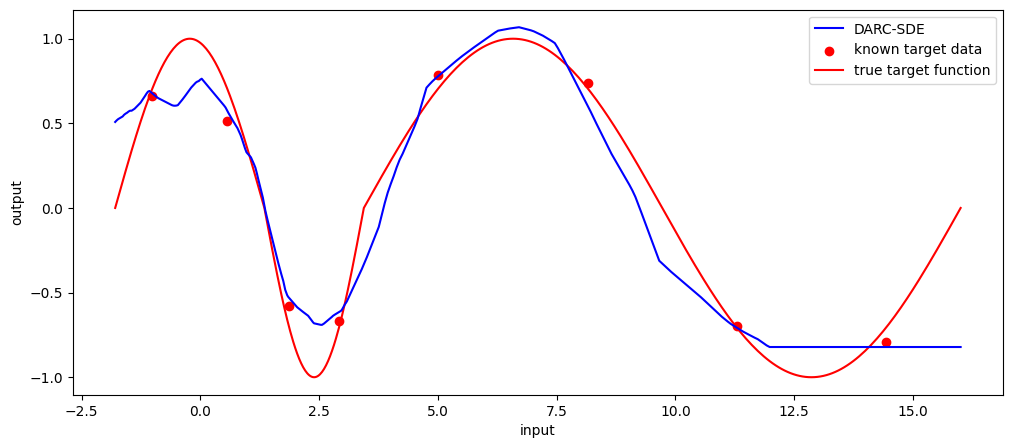

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
# MLPR = LinearRegression()
latent_source_x = torch.tensor([])
latent_source_y = torch.tensor([])
for i in range(5):
    latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
latent_source_x = np.array(latent_source_x)
latent_source_y = np.array(latent_source_y)
latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

MLPR.fit(latent_source_x, latent_source_y)
print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

plt.figure(figsize=(12,5))
plt.plot(x_t[:,[0]], MLPR.predict(latent_target_x), c='blue', label='DARC-SDE', zorder=2)
plt.scatter(x_t_labeled[:,[0]], y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t[:,[0]], y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
